In [300]:
import pandas as pd
import plotly.express as px

df = pd.read_csv("/home/piotr/Documents/mgr/uwb-rs/data-processing/2023-05-22-14:21:08.608058acc_movement_linear_lr.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.set_index(df.timestamp)
df

,Unnamed: 0,anchor,distance,instant,timestamp,acc_x,acc_y,acc_z
timestamp,,,,,,,,
2023-05-22 14:21:08.608633,0,0x6c0d,4542.8950,81420786033,2023-05-22 14:21:08.608633,16816.0,-416.0,-1312.0
2023-05-22 14:21:08.608732,1,0x6c0d,4523.1533,89659556440,2023-05-22 14:21:08.608732,16848.0,-176.0,-864.0
2023-05-22 14:21:08.865600,2,0x6c0d,4473.0340,394477304390,2023-05-22 14:21:08.865600,16928.0,-704.0,-704.0
2023-05-22 14:21:08.994296,3,0x6c0d,4459.4600,402702045220,2023-05-22 14:21:08.994296,16816.0,-480.0,-736.0
2023-05-22 14:21:09.123017,4,0x6c0d,4458.8490,410927214611,2023-05-22 14:21:09.123017,16864.0,-1040.0,672.0
...,...,...,...,...,...,...,...,...
2023-05-22 14:21:19.946251,88,0x6c0d,4531.3413,3014724230,2023-05-22 14:21:19.946251,17184.0,-1856.0,400.0
2023-05-22 14:21:20.074842,89,0x6c0d,4534.3574,11239987406,2023-05-22 14:21:20.074842,16624.0,288.0,256.0
2023-05-22 14:21:20.203361,90,0x6c0d,4549.5910,19453111629,2023-05-22 14:21:20.203361,17248.0,-672.0,32.0


In [301]:
# Calibration
stat_df = pd.read_csv("/home/piotr/Documents/mgr/uwb-rs/data-processing/2023-05-23-11:33:46.497651stationary.csv")
gravity = stat_df[["acc_x", "acc_y", "acc_z"]].mean()


In [302]:
# Lowpass filter
import matplotlib.pyplot as plt
from scipy import signal, fft

# t = df.timestamp.diff().mean()
# fs = 1 / (t.to_pytimedelta().microseconds/10**6)
# fn = fs/2

# f_filter = 20.0
# f_filter_n = f_filter / fn


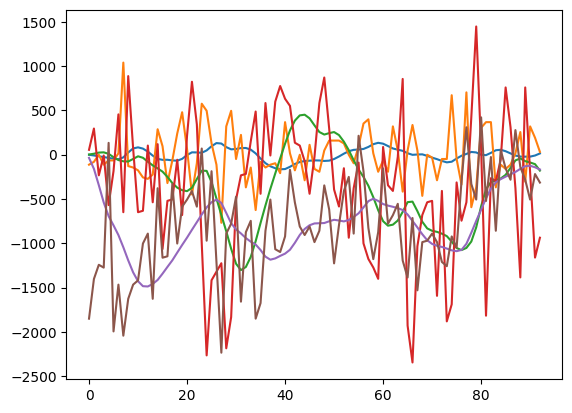

In [303]:

# freq = fft.fft(df["acc_x"].to_numpy())

def low_pass(x, Wn: float = 0.1):
    # b, a = signal.butter(4, Wn, btype="lowpass")
    b, a = signal.iirfilter(2, Wn, btype="lowpass")
    s = signal.lfilter(b,a,x)
    plt.plot(s)
    plt.plot(x.reset_index(drop=True))
    return s


# df["acc_y"] = df["acc_y"].to_frame().apply(low_pass)
df[["acc_x", "acc_y", "acc_z"]] = (df[["acc_x", "acc_y", "acc_z"]] - gravity).apply(low_pass)

<Axes: xlabel='timestamp'>

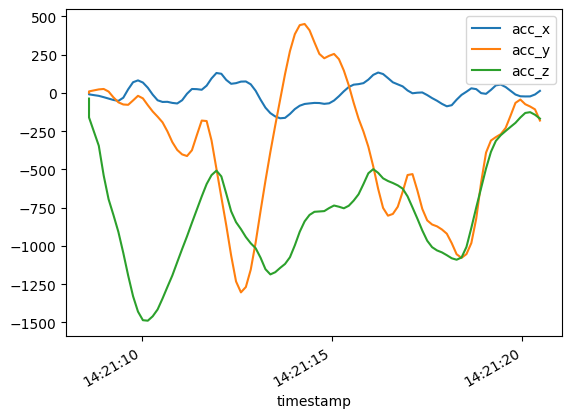

In [304]:
df[["acc_x","acc_y", "acc_z"]].plot.line()

In [305]:
# df[["velocity_x","velocity_y", "velocity_z"]] = df[["acc_x", "acc_y","acc_z"]].diff().rolling(window=1).mean().cumsum()
from scipy import integrate
import numpy as np

dv = df[["acc_x", "acc_y", "acc_z"]].expanding().apply(lambda g: integrate.trapezoid(g, g.index.astype(np.int64) / 10**9))
# dv = df[["acc_x", "acc_y", "acc_z"]].rolling("1s", min_periods=1).mean().cumsum()

px.line(dv, title="Velocity")
# df[["pos_x","pos_y", "pos_z"]] = df[["velocity_x","velocity_y", "velocity_z"]].cumsum()

In [307]:
dpos = dv[["acc_x", "acc_y", "acc_z"]].expanding().apply(lambda g: integrate.trapezoid(g, g.index.astype(np.int64) / 10**9))
# dpos = dv[["acc_x", "acc_y", "acc_z"]].rolling("1s", min_periods=1).mean().cumsum()
df[["pos_x", "pos_y", "pos_z"]] = dv[["acc_x", "acc_y", "acc_z"]].rolling("1s", min_periods=1).mean().cumsum()
px.line(dpos, title="Position")

In [308]:
import plotly.express as px

# px.line(df, x="timestamp", y="vector")

In [309]:

# px.line(df, x="timestamp", y=["velocity_x", "velocity_y", "velocity_z"])

In [310]:
px.line(df, x="timestamp", y=["pos_y", "pos_z"])

In [311]:
px.line(df, x="pos_y", y="pos_z")
# px.line_3d(df, x="pos_x", y="pos_y",z="pos_z")

In [312]:
px.scatter(df, x="pos_y", y="pos_z", animation_frame="timestamp",
            range_x=[df["pos_y"].min(), df["pos_y"].max()],
            range_y=[df["pos_z"].min(), df["pos_z"].max()]
            )